# Classification of Heart Diseases

######  Adam Bielski - December 2019

![](https://www.health.harvard.edu/media/content/images/p2_QA_MLJuly19_gi484761271.jpg)

# 1. Introduction   

This kernel is devoted to finding best-performing classification algorithms with use of hyperparameter tuning, which will be preceded by a comprehensive exploratory analysis with data visualisation. Having found the best algorithm, we'll try to recognise patients with heart diseases given a couple of features describing their health condition. I hope that everyone reading this will find this kernel informative. 

# 1.1 Loading the data set and libraries

In [ ]:
# Importing necessary libraries

import pandas as pd                                                  # DataFrames
import numpy as np                                                   # Mathematical operations
import seaborn as sns                                                # Visualisations
import matplotlib as mplt                                            # Visualisations
import matplotlib.pyplot as plt                                      # Visualisations

import scipy.stats as s                                              # Statistics functions
from scipy.stats import norm, pareto, expon, normaltest, chi2        # Statistics functions
import statsmodels.api as sm                                         # Statistics functions
import statsmodels.discrete.discrete_model as log                    # LogisticRegression
from sklearn.linear_model import LogisticRegression                  # LogisticRegression
from sklearn import svm                                              # SVM


from patsy import dmatrices                                          # Matrix with interactions
import random
import warnings
import itertools


# To speed up run of the kernel, we'll hush down all warnings (it's not advisable to do it at the design stage)
warnings.filterwarnings("ignore")


# Setting seed for repropructive purposes
random.seed(10)

In [ ]:
df = pd.read_csv("../input/heart-disease-uci/heart.csv")

# 1.2. Quick look at the data

The dataset is quite small, having 13 explanatory variables across 303 observations. At first sight, it seems that unless the features are solid predictors for heart disease, we may face difficulties identifying the pattern of ill patients, and even if we score high on any measure of accuracy, there still might a lurking possibility that we'll overfit. Therefore, as it is the case with small dataset, we need to carefully consider the appropriate way for train/test split (especially the proportions).

In [ ]:
df.shape

In [ ]:
df.head()

**Below you can find the description of the data.**

Variable name | Description 
--------------|-------------
age      | Age in years
sex |  Female or male
cp | Chest pain type (typical angina, atypical angina, non-angina, or asymptomatic angina)
trestbps | Resting blood pressure (mm Hg)
chol | Serum cholesterol (mg/dl)
fbs | 	Fasting blood sugar (< 120 mg/dl or > 120 mg/dl)
resetcg | Resting electrocardiography results (normal, ST-T wave abnormality, or left ventricular hypertrophy)
thalach | 	Max. heart rate achieved during thalium stress test
exang | Exercise induced angina (yes or no)
oldpeak | 	ST depression induced by exercise relative to rest
slope | 	Slope of peak exercise ST segment (upsloping, flat, or downsloping)
ca | Number of major vessels colored by fluoroscopy
thal | Thalium stress test result (normal, fixed defect, or reversible defect)
target | Heart disease status: number of major vessels with >50% narrowing (0,1,2,3, or 4)

A great obstacle in a successful analysis of the dataset is the lack of deep domain expertise (in biology/medicine) on my part, which cripples my ability to, in a corect manner, exploit variables or let alone interpret their effects on the outcome. 

**There are no missing values.**

In [ ]:
pd.isna(df).any()

We should also check the correctness of coding in relation to the description.

In [ ]:
df.describe()

**Two points worth noting:**

* The target variable is binary instead of having 4 values (as written in the description). It's reasonable to assume that one value indicates a heart disease (let's say, at least one major vessel with >50% narrowing) and the other absence of the heart disease. Now, all we have to do is determine which value correspond to the disease or lack thereof. From our layman's perspective, we know that the probability of a poor heart conditions should surge as age increases (*ceteris paribus*). According to the calculations below, 0 should denote a heart conditions.

* As suggested by some Kaggle's user, there are two instances when 'thal' is equal to 0 (which isn't in accordance to the description), instead there should be NaN.

### Determining meanings of the target variable

We need to calculate how much the probability of a heart disease is higher for patients older than 50. The probability (here, accordin to the Bernoulli scheme) is derived simply through maximisation of the log-likelihood function (I recommend anyone reading it to do it themselves).

$$ p = \frac{\sum_{i} x_i}{n} $$, 
where $p$ is the probability of a disease, $\sum_{i} x_i$ the number of a patients (older than 50) with a heart disease, $n$ is the number of patients older than 50.

There are more (by 1/3) older people with the target variable equal to 0. Therefore, 0 should denote a heart condition.

In [ ]:
((np.sum(df.loc[df['age']>50, 'target']))/(np.sum(df.loc[df['age']<50, 'target'])))*(np.sum(df['age']<50)/np.sum(df['age']>50))

### Corections

Corrections as to the **target** variable and the **thal** variables.

In [ ]:
# Target
df['target'] = df['target']+1
df.loc[df['target']==2, 'target'] = 0

# Thal
df.loc[df['thal']==0, 'thal'] = np.nan

# 1.3. Data wrangling

We ought to rename the columns to make their names more intuitive.

In [ ]:
df = df.rename(columns={'cp':'chest_pain', 'trestbps':'blood_pressure', 'fbs':'blood_sugar', 'restecg':'cardio', 'thalach':'heart_rate', 'exang':'ex_angina', 'oldpeak':'ST_depression', 'ca':'vessels_coloured'})
df2 = df.copy()
df3 = df.copy()

Assigning names to factor values for visualisation purposes.

In [ ]:
# CHEST PAIN
df.loc[df['chest_pain']==0, 'chest_pain'] = 'asymptomatic'
df.loc[df['chest_pain']==1, 'chest_pain'] = 'typical'
df.loc[df['chest_pain']==2, 'chest_pain'] = 'atypical'
df.loc[df['chest_pain']==3, 'chest_pain'] = 'non_anginal'


# CARDIO
df.loc[df['cardio']==0, 'cardio'] = 'left_ventricular_hypertrophy'
df.loc[df['cardio']==1, 'cardio'] = 'normal'
df.loc[df['cardio']==2, 'cardio'] = 'wave_abnormality'


#SLOPE
df.loc[df['slope']==0, 'slope'] = 'downsloping'
df.loc[df['slope']==1, 'slope'] = 'flat'
df.loc[df['slope']==2, 'slope'] = 'upsloping'


#THAL
df.loc[df['thal']==1, 'thal'] = 'fixed_defect'
df.loc[df['thal']==2, 'thal'] = 'normal'
df.loc[df['thal']==3, 'thal'] = 'reversable_defect'

Creating dummy variables for nominal variables - some algorithms require the nominal variables to be split into dummy variables.

In [ ]:
for i in ['chest_pain', 'cardio', 'slope', 'thal']:
    df = df.merge(pd.get_dummies(df[i], prefix=str(i)), right_index=True, left_index=True)
    df2 = df2.merge(pd.get_dummies(df[i], prefix=str(i)), right_index=True, left_index=True)

# 2. Exploratory analysis

# 2.1. General overview

Now, we will try to capture some dependencies between variables, and then use acquired knowledge by contructing our model. 

To gather basic information, it's advisable to visualise relations between all variables by plotting them (each variable versus each). The preliminary overview can also be presented with an aid of the correlation matrix, however, it doesn't convey as much information as a graph. Besides, correlation matrix assumes that the interaction between two variables is linear, which doesn't often hold. Lastly, it fails to show association between nominal variables.

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.heatmap(df2.corr())

In [ ]:
sns.pairplot(df3, hue='target')

In [ ]:
sns.pairplot(df3, hue='target', x_vars=['age', 'sex', 'heart_rate', 'slope', 'ST_depression', 'target'], y_vars=['age', 'sex', 'heart_rate', 'slope', 'ST_depression', 'target'])

After having scanned through the aggregated graph above, we can conclude that there is a negative relationship between variables: **age** and **heart rate**, and between **slope** and **depression**. In addition, variables: **thal**, **vessels_coloured**, **cardio** appear to have values which are underrepresented (some values of those variables make up small percentage of all values of the given variable). Therefore, we're going to have to decide whether or not to merge underrepresented values with other values. The dataset also seems to include some outliers (esp. in **depression**, **chol**, **blood_pressure**). While excluding outliers from an analysis, one should be extremely cautious, since excluding them may deteriorate the performance of an algorithm, nonetheless. 

In [ ]:
ax = sns.lmplot('age', 'heart_rate', hue='target', col='target',ci=95, data=df, order=1).set(ylabel="Heart rate", xlabel='Age').fig.suptitle("Effects of age on heart rate", fontsize=25, x=0.53, y=1.05, fontstyle='oblique')

The **heart_rate** variable refers to the maximum heart rate achieved during thalium stress test. Intuitively, it seems logical to assume that the higher rate indicates the satisfactory condition of heart, since it managed to increase its rate to such a level during the stress test. In accordance with our presupposition, the maximum heart rate is lower for those diagnosed with heart diseases and the difference is the larger, the younger a patient is. Given this finding, one can also presume that the poor heart condition can be easier noticed/recognised in younger patients, since the older patients are more prone to have a heart disease. Nevertheless, this is still to be proven.

In [ ]:
sns.boxplot('slope', 'ST_depression', data=df).set(ylabel="St depression", xlabel='Slope')
plt.title("Differences in means of 'St_depression' in relation the slope", y=1.05, fontsize = 16, fontstyle='oblique')


We've managed to capture some dependency between the slope of the peak exercise ST segment and ST depression. Due to lack of the domain expertise in medicine on my part, I find it particularly hard to find any interpretation of this phenomenon, let alone determine whether it can be pinpointed to the causal effect or it should be regarded as a spurious correlation.

Aside from **St_depression**, **age** seems to vary according to **slope**. To measure the effect of **age** on the **slope** we can draw on the analysis of covariance (*ANCOVA*). It'll check if the means of **age** for each slope are significantly different. More formally, the aim of the ANOVA is to see whether the variance between groups is significantly larger than the variance within group (if it is then the grouping variable recognizes some distinct clusters). In the ANCOVA case, we take into consideration also the covariates in order to increase the statistical power of the test (increase the probability of rejecting the null hypothesis, stating that there are no significant differences).

To show inuition behind the ANCOVA, we can break down the variable into the following components.



$${\displaystyle y_{ij} =\mu +\tau _{i}+\mathrm {B} (x_{ij}-{\overline {x}})+\epsilon _{ij}.}$$,



where $y_{ij}$ is the $j^{th}$ observation of the variable of interest under the  $i^{th}$ categorical group,  $x_{ij}$ is the $j^{th}$ observation of the covariate under the $i^{th}$  group, $\mu$ is the grand mean and $\overline {x}$  the global mean.
The variables to be fitted are $\tau _{i}$ (the effect of the $i^{th}$ level of the IV), *B* (the slope of the line) and $\epsilon _{ij}$ (the associated unobserved error term for the $j^{th}$ observation in the $j^{th}$ group). The equation can be transformed as:



$$ {\displaystyle y_{ij} -\mu  =\tau _{i}+\mathrm {B} (x_{ij}-{\overline {x}})+\epsilon _{ij}.} $$



$$ {\displaystyle Total\_variability = Between\_variability +\mathrm {B} * Covariates\_variability + Random\_variability.} $$




The goal is to check whether the *tau* is statistically significant - statistically significance differences in **age** grouped by **slope**.

In [ ]:
# Calculating mean of age for each level of slope
mean_up = np.mean(df.loc[df['slope']=='upsloping', 'age'])
mean_flat = np.mean(df.loc[df['slope']=='flat', 'age'])
mean_downsloaping = np.mean(df.loc[df['slope']=='downsloping', 'age'])

# Grand mean
grand_mean = np.mean([mean_up, mean_flat, mean_downsloaping])
variab_y = df['age']-grand_mean
diff_blood_pressure = df['blood_pressure'] - np.mean(df['blood_pressure'])
diff_blood_sugar = df['blood_sugar'] - np.mean(df['blood_sugar'])
diff_heart_rate = df['heart_rate'] - np.mean(df['heart_rate'])


X = pd.DataFrame(np.ones(303), columns=['tau']).merge(diff_blood_pressure, left_index=True, right_index=True).merge(diff_blood_sugar, left_index=True, right_index=True).merge(diff_heart_rate, left_index=True, right_index=True)
from statsmodels.graphics.gofplots import qqplot


est = sm.OLS(variab_y, X)
est2 = est.fit()
print(est2.summary())

There doesn't seem to be relevant differences in **age** in relation to **slope**.

# 2.2. Age

In [ ]:
sns.despine(left=True)
sns.kdeplot(df.loc[df['target']==1,'age' ], bw=1.5, label="target - 1")
sns.kdeplot(df.loc[df['target']==0,'age'], bw=1.5,label="target - 0")
plt.title("Distributions of age by presence of heart disease", y=1.05, fontsize = 16, fontstyle='oblique')

Healthy patients are, more or less, uniformly distributed in age ranging 40-60, in contrast to those diagnosed with a heart condition which center around the age of 60 and are relatively underrepresented in the age band 30-50. It doesn't come as surprise to us that older people are more prone to medical conditions. What we might be interested in, is a potential  "moderating" effect of the gender on the distribution of age in relation to the target. 

In [ ]:
g = sns.catplot(y='age', x='sex', data=df, hue='target', kind='violin', inner="quart", split=True, palette={0: "y", 1: "b"}).set(ylabel="Age", xlabel='Gender', xticklabels=['female', 'male']).fig.suptitle("Importance of sex and age on heart disease", fontsize=20, x=0.53, y=1.05, fontstyle='oblique')

**Distribution of sex conditioned on age**

In [ ]:
df.groupby(['sex'])['target'].value_counts()

It seems that we have imbalanced data, which has a twofold nature. Firstly, women make up 32% of the sample, secondly, the diagnosed women acount for 27% of the total number of women, whereas as far as men are concerned, this fraction equals 45%. The first question that comes to our minds is why women are twice less likely to appear in our sample. Possibly, women are, in fact, less probable to have a heart conditions, proof of which can be seen in the target ratio within genders, but also in the sheer number of women, more healthy on average, thus, subjected to examination equally more seldom. To tell the truth, we are in no position to check the plausibility of such scenarios, but all the same, we'll assume that the gender of a patient is random and there's no hidden bias in choosing patient with a given gender. 

Furthermore, when it comes to the men, the distribution of diagnosed are pretty much similar to one of the healthy, except for the fact that it's shifted towards the greater age for the former. Other than that the both distribution share common characteristics. Quite differently, the distribution of the ill women has a considerably lower variance than that of the healthy. This implies that, in reality, there are no women with heart conditions below 50, and the age, for women, is a better predictor of being healthy than for men.

# 2.3. Chest pain

In [ ]:
sns.countplot(x='chest_pain', hue='target', data=df, dodge=True).set_xlabel('Chest pain')
plt.title("Heart disease by chest pain", y=1.05, fontsize = 16, fontstyle='oblique')

In [ ]:
chi = np.round(s.chi2_contingency(pd.crosstab(df['chest_pain'], df['target']))[1], 4)
print("The p-value for chi_squared test of independence equals to ",chi, '.')

The chest paint seems to be an important variable for prediciting the heart disease.

# 2.3. St depression

In [ ]:
sns.distplot(df.loc[(df['target']==0), 'ST_depression'], kde_kws={'color':'b', 'label':'target - 0', 'lw':5, 'alpha':0.4})
sns.distplot(df.loc[(df['target']==1), 'ST_depression'], kde_kws={'color':'r', 'label':'target - 1', 'lw':5, 'alpha':0.4})
plt.title("Distribution of ST depression", y=1.05, fontsize = 16, fontstyle='oblique')

**The distribution of ST_depression differs significantly for patients with disease and healthy ones**

With the presence of the heart disease, values of **ST_depression**, on average, increase, but the contrast between values of **ST_depression** in relation to the target variable is especially noticeable at the value of 0, which equals the absence of **ST_depression** - that is, for healthy patients it is substantialy more common to have the **ST_depression** equal to 0. Therefore, we'll create a dummy variable informing whether a patient's **ST_depression** equals 0, as we suspect that it might carry additional information for our model apart from being a value at the scale. Hopefully, this will improve the performance of our algorithms.

Almost all machine learning algorithms (beside LDA or QDA) don't require normality from variables, yet the severe skewness of variables should attract our attention and make us think of a possible origin of such a distribution. The most common plausible explanations are as follows:

1) variable (consequently entire sample) comes from a non-homogenous population (especiably visible when the distribution is evidently non-unimodal, then it may suggest that you sample from two or more quite distinct population)     
2) sample is not representative (each individual didnt't have equal chance to be picked from population) due to the sample bias, thus, not enabling us to infer about the population         
3) a variable, indeed, has a different (non-normal) distribution

In the case of the last option, if the data is severely skewed, it's reasonable to assume that there'll be no linear relationship with a given variable and the outcome. Therefore, if we are going to use algorithms such as the logistic regression that assumes linearity (of independent variable and log-odds), then if the relationship isn't linear then the estimates will be baised. Besides, in transforming the data so that their distribution is more symmetric, you can often improve the performance of algorithms. Whether it'll do so, we'll find out soon.

There are reasonable grounds to believe that the **ST_depression** variable is log-normally distributed, the empirical one - the distribution of the sample -, and the theoretical one -  as many processes in biology/medicine/chemistry do have such a distribution. It arises from the fact that processes, in those areas, are the statistical realization of the multiplicative product of many independent random variables, rather than additive one (as in the case of the normal distribution).

### Choosing suitable transformation

** We want to log-transform the variable, however, we need to resolve the issue of having 0's in our variable, which obviously cannot be transformed with logarithm. To shed a light of this problem, we need to understand a couple of useful concepts.**

At the very beginning, let's remind the elementary properties of the expected value - $E()$ and the variance - $Var()$:

$$ E[X+c] = E[X]+E[c] = E[X] + c $$

$$ Var[X+c] = E[(X+c)^2] -E[X+c]^2 = E[X^2] + 2E[X]c + E[c^2] - E[X]^2 - 2E[X]c - E[c]^2 = E[X^2] - E[X]^2 + c^2 - c^2 = Var(X)  $$

However, when it comes to the expected value of logairthm, we can only estimate its value using Taylor expansion around $ x_0=E[x]$.

$$E[log(x)]≈log(E[x])−\frac{Var[x]}{2E[x]^2} $$

We would like to add such a constant (becauase we want to shift the distribution a little bit so that there are no 0 values) that won't much bias the estimates of the expected value and the variance (which we assume to be the main characteristics of the normal distribution to which through log-transformation we want the variable to transform). In order to achieve it, we'd like to minimize the difference in expected value ($E[log(x)] - E[log(x+b)]$) and variance between the log-transformed variable and the log-transformed variable with a constant shift.

$$ E[log(x)] - E[log(x+b)] = log(E[x]) - log(E[x+b])+\frac{Var[x+b]}{2E[x+b]^2}-\frac{Var[x]}{2E[x]^2} = log(E[x]) - log(E[x]+b) + \frac{Var(x)}{2(E[x]^2+2bE[x]+b^2} - \frac{Var(x)}{2E[X]^2} = -0.4974 - log(1.0396+b) + \frac{0.5796}{1.0808+2.3184*b+b^2} $$

Provided that $$ E[x] = 1.0396 $$ $$ Var[x] = 1.1592 $$


**Plotting biased arisen in relation to the value of the constant.**

In [ ]:
b = np.arange(1000)*0.02
plt.plot(b, (-0.4974 - np.log(1.0396+b) + 0.5796/(1.0808+2.3184*b+np.square(b))))

As illustrated by the graph, the smaller a constant we add, the smaller the bias becomes, which in fact is quite intuitive. However, that's only bias on the expected value, the whole distribution will inevitably change. If we want the distribution not to change the shape, we'd need to multiply it by the exponent, which will be clear after considering the following example.

We assume that $$ X \sim N(\mu, \sigma)$$  $$ Y = e^X $$  $$ Y \sim logN(\mu, \sigma) $$. 



Thus,

$$ Y*e^c = e^X*e^c = e^{X+c} = A $$
$$ log(A) \sim N(\mu+c, \sigma)  $$



In conclusion, if $ (X+c) \sim N(\mu+c, \sigma)$ then $ (Y*e^c) \sim logN(\mu+c, \sigma)$.

The results above are in line with our intuition, if we suspect that data are a result of a multiplicative process then adding a constant will be "corrupting" the ratio inherent to the data, Therefore, it poses a problem for us since by mutliplication we won't get rid of zeros from the variable. As a last resort, we could  propose to replace the 0 values by the log-normally distributed noise in interval (0, 0.5] that would be censored in a way preventing it be equal to 0, and in addition to that, include a dummy variable, about which we spoke already. Yet, that would be a viable solution if the number of 0's wasn't considerable as it is in our case. , we'll try the square-root transforation.

In [ ]:
random =  np.random.normal(0, 0.25, 303)
df['sqrt_ST_depression'] = np.sqrt(df['ST_depression'])
sns.distplot(df['sqrt_ST_depression'])

The number of 0's is still too considerable, therefore, the square-root transformation isn't the right transformation.

The log-transformation (as well as the square-transformation) with 0's doesn't yield satisfactory results, consequently it should only be recommended when we have a strong evidence to support such a transformations. To allow for the presence of the 0 values, we could consider another similar-looking distribution which allows for existence of 0's, namely the exponential distribution, whereby we could grasp the idea of **ST_depression** as an interval with length according to how long we must wait to an end of the stress test depression, yet because of the lack of theoretical background, we'll leave the variable untransformed.

# 2.4. Outliers

As has been said already, the mere fact that a set of points has extreme values, doesn't necessarily mean that we should treat those values as outliers, especially when we have a small dataset, then every observation is of value. Our main models will be logistic regression and SVM; the former is sensitive to outliers in its standard (nor regularised) form, the other while not being that sensitive to outliers (thanks to its tolerance to misclassification), still by penalizing the misclassification of outliers can influecne the objective function.  Some people may indeed have extreme values of some features (like cholesterol level), which by including in our model will acertain it that such values are indicative of the disease. Whether "outliers" have adverse effect on performance or not, will be checked by training model on two datasets.

To find points that suspected to be outliers, the mechalonobis distance is an oft-used similarity metrics. It's similar to Euclidean distance but it takes into account also the variability of the data (standard deviation) and correlation. By way of illustration, it can be thought of as a measure from a given vector to the distribution of points, consequently it well fits into explaining if a given point was drawn from the same population as the rest of points (which is in fact checking if some point/observation is outlier). Other applications include checking to which cluster of points should a point belong. Below you can find the formula of the Machalonobis distance.

$$ D_M = \sqrt{(X-\bar{X})S^{-1}(X-\bar{X})^{T}} $$

,where $ X $ is a vector in a feature space, $\bar{X}$ is vectors of means of each feature and $ S $ is a covariance matrix between features.


In [ ]:
means = lambda x: x.mean()
df_cov = df2.copy()
df_cov['thal'] =  np.where(np.isnan(df2['thal']), 2, df2['thal'])
mean = means(df_cov)
cov = np.linalg.inv(np.cov(df_cov.T)) 
machalonobis = np.diag(np.sqrt(np.dot((df_cov-mean) @ cov, (df_cov-mean).T)))

# Assuming that the test statistic follows chi-square distributed with ‘k’ degree of freedom (where k is the number of predictor variables in the model), we choose the critical value to be 0.025
chi2.ppf((1-0.05), df=14)
np.sum(machalonobis>23.11)

df_no_outliers = df2.copy()
df_no_outliers = df_no_outliers[np.isin(machalonobis, np.sort(machalonobis)[:-7])]

-(df_no_outliers.shape[0] - df.shape[0])

It seem that according to the Machalonobis distance with the critical value of 0.05 and 14 degrees of freedom (statistic chi sqaure equal to 23), there aren't any outliers in our dataset. Yet to be perfectly certain, we'll create a copy dataset without 7 variables with highest distance and check how excluding them from the dataset will change the performance (sensitive analysis).

# 3. Predictive models

# 3.1. Train/test/validation set

**Having only 303 instances, the matter of skillful split of the data into: train, test, validation sets, is of paramount importance. With less training data, our parameter estimates will have greater variance. With less testing data, our performance statistic will have greater variance.**

With regard to the binary classification, we can estimate how large the validation set should be so that the standard error of the scores based on two outcomes (fit or not fit - such as accuracy, recall, precision) does not exceed 5%.


As we remember the standard error is calculated according to the formula:

$$ se=\frac{sd}{\sqrt{n}} $$
, where $se$ - standard error, $sd$ standard deviation, $n$ - the size of a sample


For a Bernoulli trial the standard devaition is given as:

$$ sd = \sqrt{p(1-p)} $$

In our case, $p$ is the probability of a correct classification (in the case of accuracy a set of $\{(1, 1), (0, 0)\} $ indicates success of a correct classification and the other set of $\{(0, 1), (1, 0)\} $ indicates failure of a correct classification - for the scores recall/precision one can construct similar binary outcomes). Obviously, we don't know the true $p$, we can only assume the worst case scenario, when $p=1/2$, because then then $sd$ is the greatest. Therefore,

$$ \sqrt{n}>\frac{\sqrt{0.5*0.5}}{0.05} \implies n>100  $$ 

 
In the worst case scenario, a sample has to have more than 100 . Actually glancing through other kernels, I saw that the average accuracy was in the region of 85%.

With prior probability of correct classification equal to 0.85, we calculate the size of our validation set.

$$ \sqrt{n}>\frac{\sqrt{0.85*0.15}}{0.05} \implies  n>49 $$

, which in fact is pretty similar if we had gone with the "20/80 rule" that is often used by splitting dataset into training and test sets.

In conclusion,
 
**train set - 200**  
**validation set - 250/5 = 50**   
**test set - 53 ** 

### Train-test split

In [ ]:
random_numbers_train = np.random.choice(len(df2['age']), size=250, replace=False)
random_numbers_test = np.arange(303)[(np.isin(np.arange(303), random_numbers_train))==False]
train = df2.iloc[random_numbers_train, ]
test = df2.iloc[random_numbers_test, ]


# Outliers (test set - 51, train set - 250, validation set - 48)

random_numbers_train_out = np.random.choice(df_no_outliers.index.values, size=250, replace=False)
random_numbers_test_out = df_no_outliers.index.values[(np.isin(df_no_outliers.index.values, random_numbers_train_out))==False]
train_out = df_no_outliers.loc[random_numbers_train_out, ]
test_out = df_no_outliers.loc[random_numbers_test_out, ]


# 3.2. Scaling

We have to scale (standardise) the test set with the same standard deviation and mean (of the training set).

In [ ]:
def standardise(train, test):
    train_target = train['target']
    test_target = test['target']
    train.drop(['target'], axis=1, inplace=True)
    test.drop(['target'], axis=1, inplace=True)
    means = lambda x: x.mean()
    std = lambda x: x.std()
    means_train = means(train)
    std_train = std(train)
    standard = lambda x: (x-means_train)/std_train
    train = standard(train)
    test = standard(test)
    train = pd.merge(train, train_target, left_index=True, right_index=True)
    test = pd.merge(test, test_target, left_index=True, right_index=True)
    return train, test

test.groupby(['cardio_wave_abnormality']).size()
train.groupby(['cardio_wave_abnormality']).size()
# There are only 0 instances of 'cardio_wave_abnormality' in the version without "outliers" and lambda expression calculates standard deviation to equal 0, in which case it divides the feature by 0 and generates NANs.
# Therefore, we need to remove this feature from the version without "outliers"
train_out.drop(['cardio_wave_abnormality'], axis=1, inplace=True)
test_out.drop(['cardio_wave_abnormality'], axis=1, inplace=True)

train, test = standardise(train, test)
train_out, test_out = standardise(train_out, test_out)

# 3.3. Choice of a model

**For classification, wel'll use: SVM and Logisitc Regression, and then decide for a one on the basis of scores such as: accuracy, recall, precision. The choice of those algorithms over others will be justified later after having introduced the chosen algorithms. It's crucial that we take into consideration information that we found during the exploratory analysis. After splitting the data into appropriate sets and going through differences between SVM and logistic regression, we'll dive into tuning hyperparameters of aforementioned algorithms.  **

# 3.3.1 Logistic regression and SVM

### Benefits of using the logistic regression for classification purposes

The logistic regression isn't the classification algorithm per se, since it models probabilities (actually log-odds) of a point belonging to a given class. Therefore, it takes a less stringent/safer approach by assigning only probabilities and not deciding definetly whether a point should belong to a given class. It does it, though, at the cost of accuracy and, therefore, for only classification's purposes the SVM performs usually better. On the other hand, the logistic regression can provide us with both: the significance of a variable's influence on the outcome (expressed in the so-called "p-value"), and the confidence with which a point/observation can be assigned to a class (the probability expressed in the coefficients of the log-odds ratio). Moreover, the logistic regression allows also for another kind of flexibility, namely by classifying points on the basis of the logistic regression, you can control the value of the "cutoff"-threshold of probability above which point is assigned to a class - (that is, our tolerance towards misclassification of **either** of the two classes, which is expressed in the precision/recall scores)*. There's also possibility to determine an interval of variables deemed hard to classify (the ones whose probability ranges 40% - 60%). Last but not least, the logistic regression apart from classification yields also coefficients, which are interepretable as odds ratios in contrast to the lack thereof in the of uninterpretable SVM. Yet, the logistic regression requires no collinearly among the independent variables and linearity of the independent variables with the logit, even so while performing cross-validation those assumption are sometime ignored.

### Logistic regression vs SVM

Every, roughly speaking, classification/regression algorithm consists of two components, which are to be minimized.

$$ \min_{w} \sum_{x, y}L(w^⊤x,y)+λh(w) $$

The $ L() $ function is a loss function, which expresses "unfit" of the model on the training set, the other, $ h(w) $, is a regularisation term, which is typically chosen to penalise the complexity of the model (the degree to which we want to penalise is controlled by the $ λ $ parameter) in order to prevent a model from overfitting. Of course, the SVM algorithm also has a constraint aside from the minimisation of the objective function.

Surprsingly enough, even though the logistic regression comes from the probabilistic background, whereas the SVM classifier takes more geometrical approach, they differ only with the loss function (and the SVM has already a regularisation term while the logistic regression only can be regularised).  The logistic regression minimizes the logistic loss, while the SVM classifier minimizes the hinge loss (which while being convex is bound to converge to a global minimum than a standard zero-one loss).

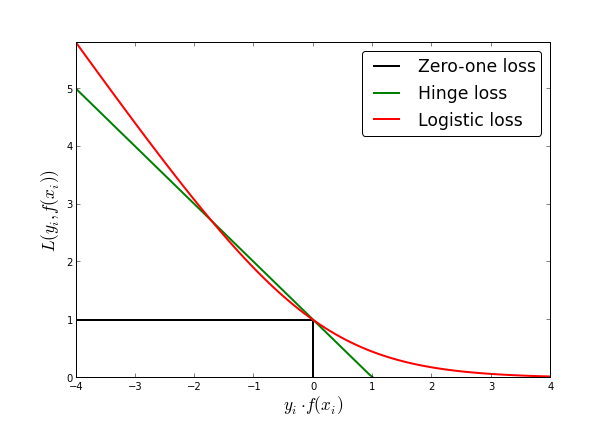

### Logistic loss

The logistic loss is a log-likelihood function (for either $y_i = 0 $ or $y_i = 1 $) derived from the Bernoulli mass function. The logistic loss is as follows:

$$ \newcommand{\Lagr}{\mathcal{L}} $$
$$ Log \Lagr(\beta) = \ell(\beta) = \sum_{i}^{n} [y_i\log(\pi_i) + (1-y_i)\log(1-\pi_i)]  $$,

where $ \ell $ is the log-likelihood function, $ n $ is the total number of observations, $ \pi $ is the probability of correctly assigning a point to a given class and $ y $ is a class indicator (either 1 or 0).

Logisitc loss has some intuitive properties. 



If $ y_i = 1 \implies \ell(\beta_i) = 1*log(\pi_i) + 0*\log(1-\pi_i) = \log(\pi_i) = \log(\frac{1}{1+e^{-X\beta}}) $   
If $ y_i = 0 \implies  \ell(\beta_i)  = 0*log(\pi_i) + 1*\log(1-\pi_i)\log(1 - \pi_i) = \log(1 - \frac{1}{1+e^{-X\beta}}) =  \log(1 - \frac{e^{X\beta}}{1+e^{X\beta}}) = \log(\frac{1}{1+e^{X\beta}})$.


if $y_i = 1 \land X\beta \rightarrow \infty$  $\implies \lim_{X\beta \to \infty} \ell(\beta_i) = \lim_{X\beta \to \infty}  \log(\pi_i) = \log(1) = 0$     
if $y_i = 0 \land X\beta \rightarrow -\infty$  $\implies \lim_{X\beta \to -\infty} \ell(\beta_i) = \lim_{X\beta \to -\infty}  \log(1-\pi_i) = \log(1) = 0$

A well-performing logistic regression is that with a low function $ \ell(\beta) $, therefore, ultimately the aim of the logistic regression is to come up with such parameters $ \beta $ that for $ \{X_0 : y_i = 0 \} \implies X_0\beta  \rightarrow -\infty $ and when $ \{X_1 : y_i = 1 \} \implies  X_1\beta  \rightarrow \infty $. Then the logit performs non-linear mapping of $ X\beta $ in a following manner $ logit([-\infty, \infty]) \rightarrow [0, 1] $ to meet the condition of bounded probability.


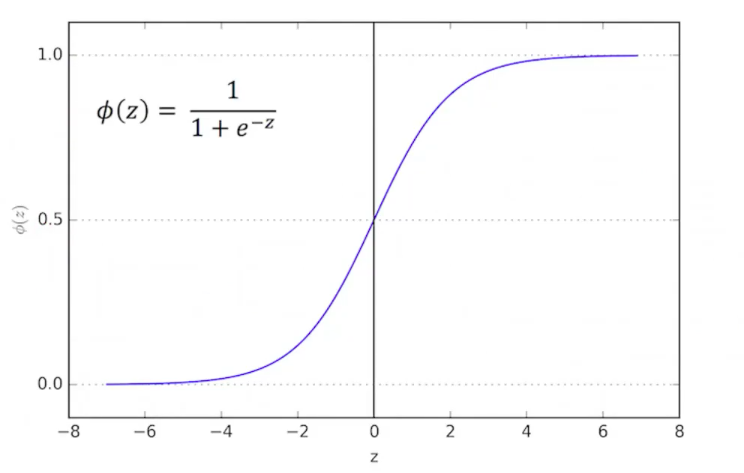

### Hinge loss

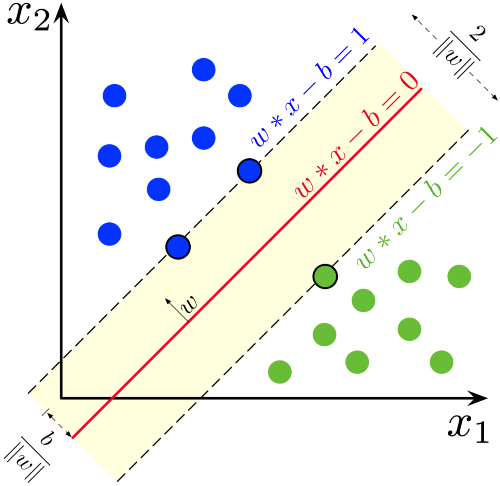

The hinge loss is derived as a result of the maxisimisation of the margin between the support vectors constrained by a condition that points must be correctly classified.
More formally:

$$ \max_{w} \frac{b}{||w||} \implies \min_{w} ||w|| $$ subject to $$ y_i(w^Tx_i + b) ≥ 1$$ for $ i = 1, ..., n $ and $ y \in \{ -1, 1\} $ depending on a class.

, where $ w $ is a parameter of $ f(x) = w^Tx + b $, which, when f(x)=0, is a decision boundary, when f(x)=1 or f(x)=-1, corresponds to a support vector.

However, we can allow some points to be missclassified and the degree to which we tolerate it is expressed in the penalty term C. 

Therefore, our final constraint looks as follows:

$$ y_i(w^Tx_i + b) ≥ 1 - \xi_i $$

, where for some $ i^{th} $ points, for which $ \xi_i \not= 0 $, we allow the constraint to be altered. 

Ergo,    
$  y_i*f(x_i)≥ 1 - \xi_i \implies \xi_i = max(0, 1-y_i*(f(x_i)) $, where hinge_loss is exactly $ max(0, 1-y_i(f(x_i)) $.

In conclusion, the aim of the SVM is to minimize: sum of distances of the misclassified points from the support vectors (hinge loss) and the margin between support vectors.

### Summing up the differences between SVM and logistic regression

**The SVM algorithm tries to find such parameters $ w $ (often called weights) ensuring that classification of both classes is the most "confident" (i.e., the closest points to being missclassified placing themselves on the suport vectors are the most distinct - separated by a possibly largest margin-, allowing at the same time for some percentage of misclassification, the rigorousness of which is controlled by the C parameter), whereas the logistic regression tries to find such parameters $ \beta $ ensuring that observations of a chosen class have been assigned higher probabilities (and observations of the other class possibly lowest). The SVM takes into consideration only points lying on the support vectors, whereas the logistic regression the whole set of points (therefore, it's possible that in exluding a lot of points from the SVM, the decision boundary may not even flinch, whereas the exclusion of every point has some marginal effect on the parameters of the logistic regression). If we're interested only in classifying points then the SVM is rather recommended, when the emphasis is shifted more to knowing the confidence (probability) of the classification then probably the logistic regression would be the best choice. Last but not least, the SVM has a regularisation term already incorporated in the algorithm, consequently it overfits less frequently (logistic regression doesn't have, by deafult, a regularisation term).**

**Having said that, it's often extremely hard to say *a prior* which one will be recommended for a given scenario.**

# 3.4 Assessing performance of the models

### Evaluating model with common statistics and scores

As such, we'd like to maximize the accuracy of the model but not necessarily at the cost of the recall. Our aim is to build an accurate predictive model, yet, we attach great importance on classifying the ill as ill, and simultaneously, can tolerate diagnosing the healthy as ones with a heart disease. The cost of falsely admitting someone to hospital is lower than the cost of "missing out" a potential patient with a heart disease (at least the social cost...). Having said that, we cannot label everyone as sick either. Choosing a right balance between recall and precision is difficult, and often, it's set based not on *a priori* known/set ratio between recall and precision but on the value of a threshold at which there is an abrupt improvement in both scores (or drastic improvement in the one of our special interest, and a moderate deterioration in the other). Accordingly, I'm not going to set a rigid ratio that will indicate the equivalency of trade-off between recall and precision, and in return we'll visualise the both scores in relation to the threshold, which should give us a clue of a perfect one.

Therefore, in the case of a model when we don't treat recall and precision scores as equally important, we cannot use scores such as F-score (being the harmonic mean of precision and recall whose formula is given by $ F1 = 2\frac{Precision*Recal}{Precision+Recall} $) or auxilliary graphs such as ROC/AUC, which can be seen below.

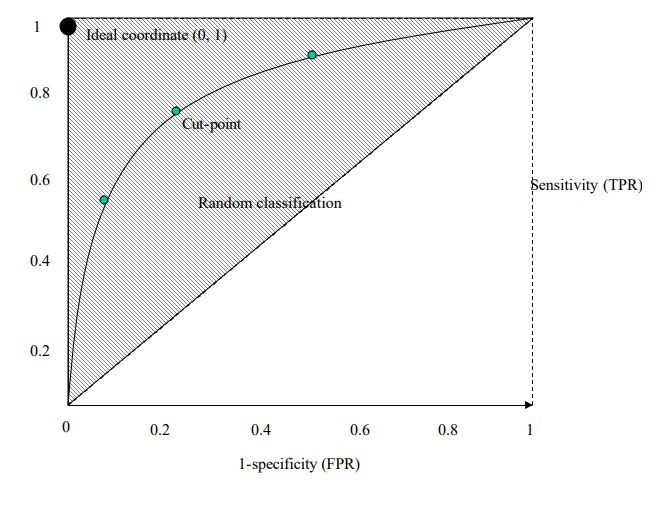

Since we have quite a small dataset at out disposable, we cannot be overly confident that the point estimate of the scores (we should remember that - the scores such as accuracy, recall, precision of a sample are estimators of such scores in the population) such as recall/precision/accuracy will be correct/accurate. It's better to draw on the interval estimates called also the confidence intervals if we don't believe the point estimates to be stable.

There are two approaches towards constructing confidence intervals: parametric and non-parametric ones. As for the former, one has to assume distribution of a statistic of which we want to calculate the confidence interval (as we assume the normal distribution of means of some variable, according to the central theorem). The non-parametric approach, however, assumes that by drawing numerous sub-samples from a given sample we can calculate statistic on each subsample, which will give us a distribution of a given statistic with regard to subsamples. Then we make an assumption that the distribution of the statistic constructed by drawing samples from the population is the same as one constructed by drawing subsamples from our sample. Having computed the distribution, we calculate $2.5^{th}$ and $97.5^{th}$ percentiles which will be bounds of an 95%-confidence interval of a statistic. The advantage of this technique is that we don't have to assume the normal distribution or any other, we "just create a distribution of our own".


### Writing functions for hyperparameterizing

Alas, I couldn't find an already written function in Python, for hyperparameterizing with monte-carlo fold validation option, which will, hopefully, minimise the loss of information for training that is occuring from creation of a validation set and reduction of the training set size. Taking advantage of writing the function by myself, I also included in it not only accuracy of models but scores such as: recall and precision, and other needed parameters.

In [ ]:
def negatives_positives_ratio(y, size, desired_lowest_ratio, desired_highest_ratio):
    y_array = np.array(y).reshape((len(y)))
    all_positions = np.arange(len(y))
    positives_position = all_positions[y_array==1]
    negatives_position = all_positions[y_array==0]
    positives_amount = int(np.sum(y==1))
    negatives_amount = int(np.sum(y==0))
    positiv_max_ratio = np.round(positives_amount/size, 2)
    if positives_amount<desired_highest_ratio*size:
        upper_bound = positiv_max_ratio
    else:
        upper_bound = desired_highest_ratio*size
    if 0.25*size<size-negatives_amount:
        lower_bound = np.round((size-negatives_amount)/size, 2)
    else:
        lower_bound =  desired_lowest_ratio*size
    print(lower_bound, upper_bound)
    positives_number_to_choose = np.round(size*np.arange(lower_bound+0.005, upper_bound, 0.005))
    return positives_number_to_choose,positives_position, negatives_position, positives_amount, negatives_amount, y_array, all_positions



def train_val_split(X, y, k, size, desired_lowest_ratio, desired_highest_ratio):
    preds=[]
    labels=[]
    accuracies=[]
    recalls=[]
    precisions=[]
    trainings_Xs=[]
    trainings_ys=[]
    val_Xs=[]
    val_ys=[]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    positives_number_to_choose,positives_position, negatives_position, positives_amount, negatives_amount, y_array, all_positions = negatives_positives_ratio(y, size, desired_lowest_ratio, desired_highest_ratio)
    for i in range(k):
        positives_number = int(np.random.choice(positives_number_to_choose, 1, replace=False))
        negatives_number = size - positives_number
        positions_train = np.concatenate((np.random.choice(positives_position, positives_number, replace=False), np.random.choice(negatives_position, negatives_number, replace=False)))
        position_val = all_positions[np.isin(all_positions, positions_train)==False]
        training_x = X.iloc[positions_train, ]
        training_y = y_array[positions_train]
        val_x = X.iloc[position_val, ]
        val_y = y_array[position_val]
        trainings_Xs.append(training_x)
        trainings_ys.append(training_y)
        val_Xs.append(val_x)
        val_ys.append(val_y)
    return trainings_Xs, trainings_ys, val_Xs, val_ys


def model_training_prediction(trainings_Xs, trainings_ys, val_Xs):
    preds=[]
    for training_x, training_y, val_x in zip(trainings_Xs, trainings_ys, val_Xs):
        model = LogisticRegression(solver='liblinear').fit(training_x, training_y)
        pred = (model.predict_proba(val_x)[:, 1]).ravel()
        preds.append(pred)
    return preds



def scores_reg(preds, labels, k, threshold, lower_bound_IC, upper_bound_IC):
    accuracy_final = {}
    precision_final = {}
    recall_final = {}
    for cutoff in threshold:
        recalls=[]
        accuracies=[]
        precisions=[]
        for counter in range(k):
            pred = preds[counter]
            label = labels[counter]
            pred = np.where(pred>cutoff, 1, 0)
            pred = np.array(pred.ravel())
#           val_y = val_y.values.reshape((np.sum(np.isin(count, a)==False)))
            TP = np.sum(np.logical_and(pred==1, label==1))
            TN = np.sum(np.logical_and(pred==0, label==0))
            FP = np.sum(np.logical_and(pred==1, label==0))
            FN = np.sum(np.logical_and(pred==0, label==1))
            accuracy = (TP + TN)/(TP + TN + FP + FN)
            recall = TP/(TP+FN)
            precision = TP/(TP+FP)
            recalls.append(recall)
            accuracies.append(accuracy)
            precisions.append(precision)
        recall_mean = np.nanmean(recalls)
        accuracy_mean = np.nanmean(accuracies)
        precision_mean = np.nanmean(precisions)
        recall_lower, recall_upper = np.nanquantile(recalls, np.array([lower_bound_IC, upper_bound_IC]))
        precision_lower, precision_upper = np.nanquantile(precisions,np.array([lower_bound_IC, upper_bound_IC]))
        accuracy_lower, accuracy_upper = np.nanquantile(accuracies,np.array([lower_bound_IC, upper_bound_IC]))
        for scores in [accuracy_mean, recall_mean, precision_mean, recall_lower, recall_upper, precision_lower, precision_upper, accuracy_lower, accuracy_upper]:
            scores = np.round(scores, 3)
        accuracy_final[cutoff] = [accuracy_lower,accuracy_mean, accuracy_upper]
        precision_final[cutoff] = [precision_lower, precision_mean, precision_upper]
        recall_final[cutoff] = [recall_lower, recall_mean, recall_upper]
    return accuracy_final, precision_final, recall_final


def K_fold_regr(X, y, k, size, threshold, lower_bound_IC=0.025, upper_bound_IC=0.975,  desired_lowest_ratio=0.25, desired_highest_ratio=0.75):
    trainings_Xs, trainings_ys, val_Xs, val_ys = train_val_split(X, y, k, size, desired_lowest_ratio, desired_highest_ratio)
    preds = model_training_prediction(trainings_Xs, trainings_ys, val_Xs)
    accuracy_final, precision_final, recall_final = scores_reg(preds, val_ys, k, threshold, lower_bound_IC, upper_bound_IC)
    return accuracy_final, precision_final, recall_final

In [ ]:
def negatives_positives_ratio(y, size, desired_lowest_ratio, desired_highest_ratio):
    y_array = np.array(y).reshape((len(y)))
    all_positions = np.arange(len(y))
    positives_position = all_positions[y_array==1]
    negatives_position = all_positions[y_array==0]
    positives_amount = int(np.sum(y==1))
    negatives_amount = int(np.sum(y==0))
    positiv_max_ratio = np.round(positives_amount/size, 2)
    if positives_amount<desired_highest_ratio*size:
        upper_bound = positiv_max_ratio
    else:
        upper_bound = desired_highest_ratio*size
    if 0.25*size<size-negatives_amount:
        lower_bound = np.round((size-negatives_amount)/size, 2)
    else:
        lower_bound =  desired_lowest_ratio*size
    print(lower_bound, upper_bound)
    positives_number_to_choose = np.round(size*np.arange(lower_bound+0.005, upper_bound, 0.005))
    return positives_number_to_choose,positives_position, negatives_position, positives_amount, negatives_amount, y_array, all_positions



def train_val_split(X, y, k, size, desired_lowest_ratio, desired_highest_ratio):
    preds=[]
    labels=[]
    accuracies=[]
    recalls=[]
    precisions=[]
    trainings_Xs=[]
    trainings_ys=[]
    val_Xs=[]
    val_ys=[]
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    positives_number_to_choose,positives_position, negatives_position, positives_amount, negatives_amount, y_array, all_positions = negatives_positives_ratio(y, size, desired_lowest_ratio, desired_highest_ratio)
    for i in range(k):
# It's possible that the subsample might have deterministically collinear variables, therefore, we include try/except expression to make the function draw another subsample if such a situation occurs 
        positives_number = int(np.random.choice(positives_number_to_choose, 1, replace=False))
        negatives_number = size - positives_number
        positions_train = np.concatenate((np.random.choice(positives_position, positives_number, replace=False), np.random.choice(negatives_position, negatives_number, replace=False)))
        position_val = all_positions[np.isin(all_positions, positions_train)==False]
        training_x = X.iloc[positions_train, ]
        training_y = y_array[positions_train]
        val_x = X.iloc[position_val, ]
        val_y = y_array[position_val]
        trainings_Xs.append(training_x)
        trainings_ys.append(training_y)
        val_Xs.append(val_x)
        val_ys.append(val_y)
    return trainings_Xs, trainings_ys, val_Xs, val_ys

    
def training_model(X, y, k, size,  classifier, param_name1, param_value1, param_name2=0, param_value2=0, param_name3=0, param_value3=0,param_add_name1='coef0', param_add_value1=0, param_add_name2='gamma', param_add_value2='auto', lower_bound_IC=0.025, upper_bound_IC=0.975,  desired_lowest_ratio=0.25, desired_highest_ratio=0.75):
    accuracies_train = []
    recalls_train = []
    precisions_train = []
    accuracies_out = []
    recalls_out = []
    precisions_out = []
    trainings_Xs, trainings_ys, val_Xs, val_ys = train_val_split(X, y, k, size, desired_lowest_ratio, desired_highest_ratio)
    for training_x, training_y, val_x, val_y in zip(trainings_Xs, trainings_ys, val_Xs, val_ys):
        if isinstance(param_name1, str) & isinstance(param_name2, str)==False:
            param = {param_name1:param_value1, param_add_name1:param_add_value1, param_add_name2:param_add_value2}
            model = classifier(**param).fit(training_x, training_y.ravel())
        elif isinstance(param_name1, str) & isinstance(param_name2, str) & isinstance(param_name3, str)==False:
            param = {param_name1:param_value1, param_name2:param_value2, param_add_name1:param_add_value1, param_add_name2:param_add_value2}
            model = classifier(**param).fit(training_x, training_y.ravel())
        elif isinstance(param_name1, str) & isinstance(param_name2, str) & isinstance(param_name3, str):
            param = {param_name1:param_value1, param_name2:param_value2, param_name3:param_value3,  param_add_name1:param_add_value1, param_add_name2:param_add_value2}
            model = classifier(**param).fit(training_x, training_y.ravel())
        else:
            raise ValueError("Parameter's name must be string")
        for error in ['out-of-sample', 'training']:
            if error=='out-of-sample':
                pred = np.array(model.predict(val_x))
                label = np.array(val_y)
            elif error=='training':
                pred = np.array(model.predict(training_x))
                label = training_y
            TP = np.sum(np.logical_and(pred==1, label==1))
            TN = np.sum(np.logical_and(pred==0, label==0))
            FP = np.sum(np.logical_and(pred==1, label==0))
            FN = np.sum(np.logical_and(pred==0, label==1))         
            accuracy = (TP + TN)/(TP + TN + FP + FN)
            recall = TP/(TP+FN)
            precision = TP/(TP+FP)
            if error=='out-of-sample': 
                recalls_out.append(recall)
                accuracies_out.append(accuracy)
                precisions_out.append(precision)
            elif error=='training':
                recalls_train.append(recall)
                accuracies_train.append(accuracy)
                precisions_train.append(precision)
    return recalls_out,  accuracies_out, precisions_out, recalls_train, accuracies_train, precisions_train

def lower_mean_upper(recalls_out, accuracies_out, precisions_out, recalls_train, accuracies_train, precisions_train, lower_bound_IC, upper_bound_IC):
    recall_mean_out = np.nanmean(recalls_out)
    accuracy_mean_out = np.nanmean(accuracies_out)
    precision_mean_out = np.nanmean(precisions_out)
    recall_mean_train = np.nanmean(recalls_train)
    accuracy_mean_train = np.nanmean(accuracies_train)
    precision_mean_train = np.nanmean(precisions_train)
    recall_lower_out, recall_upper_out = np.nanquantile(recalls_out, np.array([lower_bound_IC, upper_bound_IC]))
    precision_lower_out, precision_upper_out = np.nanquantile(precisions_out,np.array([lower_bound_IC, upper_bound_IC]))
    accuracy_lower_out, accuracy_upper_out = np.nanquantile(accuracies_out,np.array([lower_bound_IC, upper_bound_IC]))
    recall_lower_train, recall_upper_train = np.nanquantile(recalls_train, np.array([lower_bound_IC, upper_bound_IC]))
    precision_lower_train, precision_upper_train = np.nanquantile(precisions_train,np.array([lower_bound_IC, upper_bound_IC]))
    accuracy_lower_train, accuracy_upper_train = np.nanquantile(accuracies_train,np.array([lower_bound_IC, upper_bound_IC])) 
    return recall_mean_out, accuracy_mean_out, precision_mean_out, recall_mean_train, accuracy_mean_train,precision_mean_train, recall_lower_out,recall_upper_out, precision_lower_out, precision_upper_out, accuracy_lower_out, accuracy_upper_out, recall_lower_train, recall_upper_train, precision_lower_train, precision_upper_train, accuracy_lower_train, accuracy_upper_train    

    
def scores(X, y, k, size,  classifier, param_name1, param_value1, param_name2, param_value2, param_name3, param_value3, param_add_name1, param_add_value1, param_add_name2, param_add_value2, lower_bound_IC, upper_bound_IC,  desired_lowest_ratio, desired_highest_ratio):
    recalls_out,  accuracies_out, precisions_out, recalls_train, accuracies_train, precisions_train = training_model(X, y, k, size,  classifier, param_name1, param_value1, param_name2, param_value2, param_name3, param_value3, param_add_name1='coef0', param_add_value1=0, param_add_name2='gamma', param_add_value2='auto', lower_bound_IC=0.025, upper_bound_IC=0.975,  desired_lowest_ratio=0.25, desired_highest_ratio=0.75)
    recall_mean_out, accuracy_mean_out, precision_mean_out, recall_mean_train, accuracy_mean_train,precision_mean_train, recall_lower_out,recall_upper_out, precision_lower_out, precision_upper_out, accuracy_lower_out, accuracy_upper_out, recall_lower_train, recall_upper_train, precision_lower_train, precision_upper_train, accuracy_lower_train, accuracy_upper_train = lower_mean_upper(recalls_out, accuracies_out, precisions_out, recalls_train, accuracies_train, precisions_train, lower_bound_IC, upper_bound_IC)
    return recall_mean_out, accuracy_mean_out, precision_mean_out, recall_mean_train, accuracy_mean_train,precision_mean_train, recall_lower_out,recall_upper_out, precision_lower_out, precision_upper_out, accuracy_lower_out, accuracy_upper_out, recall_lower_train, recall_upper_train, precision_lower_train, precision_upper_train, accuracy_lower_train, accuracy_upper_train

def Hypertuning(X, y, k, size, classifier, params1=0, params2=0, params3=0, param_add_name1='coef0', param_add_value1=0, param_add_name2='gamma', param_add_value2='auto', lower_bound_IC=0.25, upper_bound_IC=0.975,  desired_lowest_ratio=0.25, desired_highest_ratio=0.75):
    accuracies_final_dic_out= {}
    recalls_final_dic_out = {}
    precisions_final_dic_out = {}
    accuracies_final_dic_train= {}
    recalls_final_dic_train = {}
    precisions_final_dic_train = {}
    #
    param_name1 = params1[0]
    for w in range(len(params1[1])):
        param_value1 = params1[1][w]
        if params2!=0:
            param_name2 = params2[0]
            accuracies_final_dic_out[param_value1]= {}
            recalls_final_dic_out[param_value1] = {}
            precisions_final_dic_out[param_value1] = {}
            accuracies_final_dic_train[param_value1]= {}
            recalls_final_dic_train[param_value1] = {}
            precisions_final_dic_train[param_value1] = {}
            for ww in range(len(params2[1])):
                param_value2 = params2[1][ww]
                if params3!=0:
                    param_name3 = params3[0]
                    accuracies_final_dic_out[param_value1][param_value2]= {}
                    recalls_final_dic_out[param_value1][param_value2] = {}
                    precisions_final_dic_out[param_value1][param_value2] = {}
                    accuracies_final_dic_train[param_value1][param_value2]= {}
                    recalls_final_dic_train[param_value1][param_value2] = {}
                    precisions_final_dic_train[param_value1][param_value2] = {}
                    for www in range(len(params3[1])):
                        param_value3 = params3[1][www]
                        recall_mean_out, accuracy_mean_out, precision_mean_out, recall_mean_train, accuracy_mean_train,precision_mean_train, recall_lower_out,recall_upper_out, precision_lower_out, precision_upper_out, accuracy_lower_out, accuracy_upper_out, recall_lower_train, recall_upper_train, precision_lower_train, precision_upper_train, accuracy_lower_train, accuracy_upper_train = scores(X, y, k, size,  classifier, param_name1, param_value1, param_name2, param_value2, param_name3, param_value3, param_add_name1, param_add_value1, param_add_name2, param_add_value2, lower_bound_IC, upper_bound_IC,  desired_lowest_ratio, desired_highest_ratio)
                        accuracies_final_dic_out[param_value1][param_value2][param_value3] = [accuracy_lower_out, accuracy_mean_out, accuracy_upper_out]
                        recalls_final_dic_out[param_value1][param_value2][param_value3] = [recall_lower_out, recall_mean_out, recall_upper_out] 
                        precisions_final_dic_out[param_value1][param_value2][param_value3] = [precision_lower_out, precision_mean_out, precision_upper_out]
                        accuracies_final_dic_train[param_value1][param_value2][param_value3] = [accuracy_lower_train, accuracy_mean_train, accuracy_upper_train]
                        recalls_final_dic_train[param_value1][param_value2][param_value3] = [recall_lower_train, recall_mean_train, recall_upper_train] 
                        precisions_final_dic_train[param_value1][param_value2][param_value3] = [precision_lower_train, precision_mean_train, precision_upper_train]
                else:
                    recall_mean_out, accuracy_mean_out, precision_mean_out, recall_mean_train, accuracy_mean_train,precision_mean_train, recall_lower_out,recall_upper_out, precision_lower_out, precision_upper_out, accuracy_lower_out, accuracy_upper_out, recall_lower_train, recall_upper_train, precision_lower_train, precision_upper_train, accuracy_lower_train, accuracy_upper_train= scores(X, y, k, size,  classifier, param_name1, param_value1, param_name2, param_value2, 0, 0, param_add_name1, param_add_value1, param_add_name2, param_add_value2, lower_bound_IC, upper_bound_IC,  desired_lowest_ratio, desired_highest_ratio)
                    print(param_value1, param_value2, accuracy_mean_out, accuracy_mean_train)
                    accuracies_final_dic_out[param_value1][param_value2] = [accuracy_lower_out, accuracy_mean_out, accuracy_upper_out]
                    recalls_final_dic_out[param_value1][param_value2] = [recall_lower_out, recall_mean_out, recall_upper_out] 
                    precisions_final_dic_out[param_value1][param_value2]= [precision_lower_out, precision_mean_out, precision_upper_out]
                    accuracies_final_dic_train[param_value1][param_value2]= [accuracy_lower_train, accuracy_mean_train, accuracy_upper_train]
                    recalls_final_dic_train[param_value1][param_value2] = [recall_lower_train, recall_mean_train, recall_upper_train] 
                    precisions_final_dic_train[param_value1][param_value2] = [precision_lower_train, precision_mean_train, precision_upper_train]
        else:
            recall_mean_out, accuracy_mean_out, precision_mean_out, recall_mean_train, accuracy_mean_train,precision_mean_train, recall_lower_out,recall_upper_out, precision_lower_out, precision_upper_out, accuracy_lower_out, accuracy_upper_out, recall_lower_train, recall_upper_train, precision_lower_train, precision_upper_train, accuracy_lower_train, accuracy_upper_train= scores(X, y, k, size,  classifier, param_name1, param_value1, 0, 0, 0, 0, param_add_name1, param_add_value1, param_add_name2, param_add_value2, lower_bound_IC, upper_bound_IC,  desired_lowest_ratio, desired_highest_ratio)
            accuracies_final_dic_out[param_value1]= [accuracy_lower_out, accuracy_mean_out, accuracy_upper_out]
            recalls_final_dic_out[param_value1] = [recall_lower_out, recall_mean_out, recall_upper_out] 
            precisions_final_dic_out[param_value1] = [precision_lower_out, precision_mean_out, precision_upper_out]
            accuracies_final_dic_train[param_value1] = [accuracy_lower_train, accuracy_mean_train, accuracy_upper_train]
            recalls_final_dic_train[param_value1] = [recall_lower_train, recall_mean_train, recall_upper_train] 
            precisions_final_dic_train[param_value1] = [precision_lower_train, precision_mean_train, precision_upper_train]
    return  recalls_final_dic_out, precisions_final_dic_out, accuracies_final_dic_out,recalls_final_dic_train, precisions_final_dic_train, accuracies_final_dic_train

### Feature selection

There's a heated debate whether we should select variables for the classification algorithms like SVM. Some argue that the SVM algorithm has a regularisation term (a quasi squared l2-norm penalty), which will force a coefficient (weight) of an irrelevant variable to be close to 0 if it has no effect on the outcome (as a matter of fact, if someone is certain that some of the variables are insignificant and including them in the equation may introduce noise, then it's recommended to use l1-norm, which diverges to 0 faster). 

By and large, if the feature selection is performed, it's: for generalisation purposes (e.g., understanding which genes are relevant in relation to the disease), running time requirements (e.g., pedestrain detection), computation expensiveness (training SVM takes up a lot of RAM), constraint (only some variables has to be chosen) and interpretation imposed by itself, yet, it's believed that the abundance of irrelevant features shouldn't worsen performance (although it may introduce a lot of noise when the number of irrelevant features is large, for reference look:  J. Weston et al.: Feature Selection for SVMs http://www.cs.columbia.edu/~jebara/6772/papers/weston01feature.pdf or I. Guyon and A. Elisseef, 2003). One way to deal with this conundrum is as proposed by George Forman (et al.), namely after having scaled all variables to be in an interval [0,1], to rescale them on the basis of inluence they have on the outcome (similar approach can be found in Yves Grandvalet, Stephane Canu: Adaptive Scaling for Feature Selection in SVMs: https://www.utc.fr/~grandval/nips02.pdf). Since the objective function is:

$$ \min_{w} w^Tw + \sum_{i=1}^m \xi_i $$

Under the constraints: $ w^Tx + b \geq 1 - \xi_i $ and $ \xi_i \geq 0 $.

Therefore, it's easy to notice that with larger values of some features (through rescaling them to be outside bounds of [0 ,1]), less of the regularised weight $ w_i $ is required to achieve the same effect (that is minimisation of the objective function). Also, from the geometrical perspective, it's quite intuitive that if we inflate one of the dimensions of the feature space,  points will be "stretched out" in this "direction" creating, relatively to other dimensions, vaster space allowing to fit a large-margin decision boundary. To capture relevance of variable, often the Information Gain (or other forms of measuering influence on the outcome) is drawn on (although it should be pointed that there are also other techniques, laid out by Olivier Chapelle, S. Sathiya Keerthi: http://olivier.chapelle.cc/pub/jsm_fsel.pdf, which are, I'm afraid, beyond the scope of my understanding).

Even so, the "weighted" SVM is recommended only for a large pool of features, in our case we can fall back on the logistic regression, which can be used to gauge effect of the independent variables on the outcome. Then we'll see whether the dataset with restricted features performs better.

# 3.5 Models

We're fitting the logistic regression as the first model, since, as said before, it allows us to easily select variables that siginficantly improve performance of the classification (or ones that deteriorate it), which the SVM classifier can't do. If we deem some variable insignificant (given some fixed p-value), it doesn't, of course, necessarily mean that they don't influence the outcome, only that by stating that their coefficients are different than 0 we'll be mistaken with a low probability (p-value). But even if they have some effect on the outcome, it should be nonetheless negligible.  

Generally, there are two most common approaches to the variable selection in the case of logistic regression (just like linear regression, etc...). The one being the forward selection which looks at each explanatory variable individually and selects the single explanatory variable that ﬁts the data the best - this one is included in the equation first. This is repeated until none of the remaining variables will improve performance. Backward selection starts with a model that contains all explanatory variables,and then with each step one variable deemed unsignificant is removed. This continues until all variables in the model are signiﬁcant. We'll opt for the latter for the sake of simplicity. To gauge the "significance" of the variables, we can look at their p-value. The problem with this approach is that with quite a small sample that we have, we cannot blindly follow *a priori* chosen threshold (say 5%); if we believe that some variable (such as gender, age) influence the outcome, nonetheless, then we'll include them in the equation. Apart from looking at the "p-value" one can also pay attention to the decrease/increase in the value of the likelihood function upon excluding/including a variable. Both should approaches yield comparable results.

In [ ]:
# First model: full with all variable and their interaction (of course without one variable per class of variables to avoid multicollinearity)
y, X = dmatrices('target ~ age + sex + age:sex + blood_pressure+ chol+blood_sugar+heart_rate+heart_rate:age+vessels_coloured+ex_angina+ chest_pain_non_anginal + chest_pain_typical + chest_pain_asymptomatic + cardio_left_ventricular_hypertrophy+ cardio_wave_abnormality+slope_flat+slope_upsloping+slope_upsloping:ST_depression+slope_flat:ST_depression+ST_depression+thal_fixed_defect+thal_reversable_defect', data=train)
lr = log.Logit(y, X).fit()
print(lr.summary())


# Second model: with selected variables
y2, X2 = dmatrices('target ~ age + sex + blood_pressure+heart_rate+heart_rate:age+vessels_coloured+chest_pain_atypical + chest_pain_non_anginal + chest_pain_typical + cardio_normal+slope_upsloping+slope_flat+slope_upsloping+slope_flat:ST_depression+thal_reversable_defect', data=train)
lr = log.Logit(y2, X2).fit()
print(lr.summary())

We see that the difference between two models: full and restricted, is rather not significant (the pseudo R-sqaured is decreased by only two percentages points). Nonetheless, we'll cross-validate performance of two models on validation sets. 

In total, we have 4 datasets to test, since for each of the two we've got a version with presumed outliers and without.

In [ ]:
# Creating dataset with interactions also for the dataset without "outliers"
y_out, X_out = dmatrices('target ~ age + sex + age:sex + blood_pressure+ chol+blood_sugar+heart_rate+heart_rate:age+vessels_coloured+ex_angina+ chest_pain_non_anginal + chest_pain_typical + chest_pain_asymptomatic + cardio_left_ventricular_hypertrophy+slope_flat+slope_upsloping+slope_upsloping:ST_depression+slope_flat:ST_depression+ST_depression+thal_fixed_defect+thal_reversable_defect', data=train_out)

y2_out, X2_out = dmatrices('target ~ age + sex + blood_pressure+heart_rate+heart_rate:age+vessels_coloured+chest_pain_atypical + chest_pain_non_anginal + chest_pain_typical + cardio_normal+slope_upsloping+slope_flat+slope_upsloping+slope_flat:ST_depression+thal_reversable_defect', data=train_out)


accuracies_reg, recalls_reg, precisions_reg= K_fold_regr(X, y, k=200, size=200, threshold=np.arange(0, 100, 0.5)*0.01)

accuracies_reg2, recalls_reg2, precisions_reg2 = K_fold_regr(X2, y2, k=200, size=200, threshold=np.arange(0, 100, 0.5)*0.01)

accuracies_reg_out, recalls_reg_out, precisions_reg_out = K_fold_regr(X_out, y_out, k=200, size=200, threshold=np.arange(0, 100, 0.5)*0.01)

accuracies_reg2_out, recalls_reg2_out, precisions_reg2_out = K_fold_regr(X2_out, y2_out, k=200, size=200, threshold=np.arange(0, 100, 0.5)*0.01)

We need to unpack the output of the previous function so that we have the mean of the score and $ 2.5^{th} $ and $ 97.5^{th} $ percentiles to compute confidence intervals.

In [ ]:
# Function to dismantle lower_bound, mean, upper_bound for each threshold
def lower_mean_upper_score(score):
    threshs, vals = zip(*score.items())
    means_ac = []
    lower_bound_ac=[]
    upper_bound_ac=[]
    for i in range(len(threshs)):
        means_ac.append(vals[i][1])
        lower_bound_ac.append(vals[i][0])
        upper_bound_ac.append(vals[i][2])
    return lower_bound_ac, means_ac, upper_bound_ac



lower_bound_ac, means_ac, upper_bound_ac = lower_mean_upper_score(accuracies_reg)
lower_bound_rc , means_rc , upper_bound_rc = lower_mean_upper_score(recalls_reg)
lower_bound_pr, means_pr, upper_bound_pr = lower_mean_upper_score(precisions_reg)
lower_bound_ac2, means_ac2, upper_bound_ac2 = lower_mean_upper_score(accuracies_reg2)
lower_bound_rc2 , means_rc2 , upper_bound_rc2 = lower_mean_upper_score(recalls_reg2)
lower_bound_pr2, means_pr2, upper_bound_pr2 = lower_mean_upper_score(precisions_reg2)
lower_bound_ac_out, means_ac_out, upper_bound_ac_out = lower_mean_upper_score(accuracies_reg_out)
lower_bound_rc_out , means_rc_out , upper_bound_rc_out = lower_mean_upper_score(recalls_reg_out)
lower_bound_pr_out, means_pr_out, upper_bound_pr_out = lower_mean_upper_score(precisions_reg_out)
lower_bound_ac_out2, means_ac_out2, upper_bound_ac_out2 = lower_mean_upper_score(accuracies_reg2_out)
lower_bound_rc_out2 , means_rc_out2 , upper_bound_rc_out2 = lower_mean_upper_score(recalls_reg2_out)
lower_bound_pr_out2, means_pr_out2, upper_bound_pr_out2 = lower_mean_upper_score(precisions_reg2_out)


lower_bound_acs = [lower_bound_ac, lower_bound_ac2, lower_bound_ac_out, lower_bound_ac_out2]
mean_acs = [means_ac, means_ac2, means_ac_out, means_ac_out2]
upper_bounds_acs = [upper_bound_ac, upper_bound_ac2, upper_bound_ac_out, upper_bound_ac_out2]

In [ ]:
colors=['#003f5c', '#f95d6a' ,'#665191', '#ffa600', '#d45087', '#f95d6a', '#820401', '#ff7c43', '#f0a58f']
legends = ['full model', 'reduced model', 'full model no-outlier', 'reduced model no-outliers']

fig, ax = plt.subplots(1, 1, figsize=(12,10))
for score_lower, score_mean, score_upper, color, legend in zip(lower_bound_acs, mean_acs, upper_bounds_acs, colors, legends):
    ax.plot(np.arange(0, 100, 0.5)*0.01, np.round(score_mean, 3), label=legend, color=color)
    ax.legend(loc='upper right')
    ax.fill_between(np.arange(0, 100, 0.5)*0.01, np.round(score_lower, 3), np.round(score_upper, 3), alpha=.1, color=color)
ax.set_xlabel('Threshold', size=15)
ax.set_ylabel('Score', size=15)
ax.set_title('The comparison of accuracy between models \n With confidence interval 95%', fontsize=25, x=0.53, y=1, fontfamily='sans-serif', fontweight="bold")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(np.arange(0, 100, 0.5)*0.01, means_rc, color='#ff7c43', label='Recall')
ax.set_ylabel('Score', size=15)
ax.set_xlabel('Threshold', size=15)
ax.legend(loc='upper right')
ax.fill_between(np.arange(0, 100, 0.5)*0.01, lower_bound_rc, upper_bound_rc, alpha=.3, color='#ff7c43')
ax.plot(np.arange(0, 100, 0.5)*0.01, means_pr, color='#820401', label='Precision')   
ax.legend(loc='upper right')
ax.fill_between(np.arange(0, 100, 0.5)*0.01, lower_bound_pr, upper_bound_pr, alpha=.3, color='#820401')
ax.set_title('The comparison between Recall and Precision \n With confidence interval 95%', fontsize=25, x=0.53, y=1,  fontfamily='sans-serif', fontweight="bold")

## Comment to graphs

As suspected the optimal "cutoff" of the logistic regression lies in the region of 0.5. There isn't any significant difference between the four models, but all the same it seems that the full model performs marginally better, and besides, when in doubt choosing model, we should aim for the one that makes the least assumptions.

## SVM

**The Support Vector Machine is believed, by the researchers, to be one of the most effective classification algorithm.**

After having decided for the support vector machine classification, we have to choose two main parameters: C parameter and kernel function. Starting with the latter, hardly ever will you know which would be the most suitable for a given dataset and problem, only on the basis of the theoretical knowledge. Presumably, the linear kernel may sometimes be chosen just on the belief that the points are linearly separable, especially when there are no complicated interaction effects of independent variables on the outcome. Although, intuitively, the linear kernel may appear not to perform well for its lack of flexibility, it turns out to be quite commonly used especially for the fact that it generalizes well with small training sets. 


The linear kernel
$$ K(x,y)=x^Ty $$

If one suspects that data aren't linearly separable (or checked it empirically), another recommendable kernel is the radial basis function kernel.

$$ K(x,y)=e^{−γ∥x−y∥^2} $$

Looking at its formula, it's easy to notice this kernel yield the higher values the closer points are to each other. Therefore, in contrast with other kernels, this one has a property of  *translation invariance*: (a property holding that $ K(x,y)=K(x+a,y+a) $), which means that it's sensitive to relative distances but not to absolute values (magnitude). In addition, the rbf is based on the Euclidean distance as opposed to the dot product as in other kernels. The most important difference between these two measures of similarity, is that the dot product measures the distance **from the origin** (actually to be precise it projects one vector onto another, the distance of which, with the aid of imagination, is clearly dependant on the angle between the two vectors but also on their **absolute magnitude**)  whereas the euclidean distance **from each other**. The distinction is especially visible when considering the following example, let's suppose $ x = (1, 1)$ and $ y = (-1, 1) $. Then the dot product $ <(x) | (y)> $ is equal to 0 (which indicates orthogonality/perpendicularity), which suggest that vector are completely different, whereas the Euclidean distance is small, indicating similarity. In conclusion, if, in a given dataset, the magnitude of vectors isn't crucial (just the proportion of features in a vector) then rbf should be chosen.

Apart from different similarity measure, the rbf kernel allows us also to tweak $\gamma$ paramater, which for high values classify only close points to the same class (therefore ovefit), for low values underfit.


As a general rule, one chooses either the linear or rbf kernel, however, if the dataset in question isn't to big, it's always a good practice to hyperparameterize the choice of the kernel through cross-validation. One of the most known advantage of the SVM algorithm is that it handles dataset with many features well, however, when the number of features is considerably large, it may be advisable not to use the rbf due to computation time.

Other popular kernels are as follows:

The polynomial kernel
$$ K(x,y)=(\gamma*x^Ty+c)^d $$

The sigmoid kernel

$$ K(x,y)=tanh(\gamma*x^Ty+c) $$

, where $c$ and $\gamma$ are additional parameters.

### Writing function to visualise accuracy/recall/precision

In [ ]:
def mean_bounds(score):
    means=[]
    lower_bound=[]
    upper_bound=[]
    for i in list(score.keys()):
        lower_bound.append(score[i][0])
        means.append(score[i][1])
        upper_bound.append(score[i][2])
    return means,lower_bound, upper_bound


def graph_auc(xs, axs, upper, lower, mean, row, col, algorithm_name, method, color):
    axs[col, row].plot(xs, mean, color=color)
    axs[col, row].fill_between(np.arange(len(lower)), lower, upper, alpha=.1, color=color)
    axs[col, row].set_title('{} {}'.format(algorithm_name, method), size=25, y=1.02, fontfamily='serif')

                                                                                      
                                                                                      
def graph_pr_rc(xs, axs, upper_recall, lower_recall, upper_precision, lower_precision,  mean_recall, mean_precision, row, col, algorithm_name, method, color):
    axs[col, row].plot(xs, mean_recall, linestyle='-', color=color)
    axs[col, row].plot(xs, mean_precision, linestyle='-.', color=color)
    axs[col, row].fill_between(np.arange(len(lower_recall)), lower_recall, upper_recall, alpha=.1, color=color)
    axs[col, row].fill_between(np.arange(len(lower_precision)), lower_precision, upper_precision, alpha=.1, color=color)
    axs[col, row].set_title('{} {}'.format(algorithm_name, method), size=25, y=1.02, fontfamily='serif')
                                                                              
                                                                                      
                                                                                                     
                                                                                      
def drawing_ac_pr_rc(ac_score_values_out, pr_score_values_out, rc_score_values_out, ac_score_values_train, pr_score_values_train, rc_score_values_train, algorithm_name, additional_param_name1, additional_param_name2, palette_colours=['#003f5c', '#ff7c43', '#665191', '#ffa600', '#d45087', '#f95d6a', '#820401', '#f0a58f']):
    methods = list(ac_score_values_out.keys())
    method = list(ac_score_values_out.keys())[0]
    method2 = list(ac_score_values_out[method].keys())[0]
    if isinstance(ac_score_values_out[method][method2], list):
        dic_levels=2
        xticks = np.arange(0, len(list(ac_score_values_out[method].keys())), 1)
        xtick_labels = [str(i) for i  in list(ac_score_values_out[method].keys())]
    else:
        dic_levels=3
        xticks = np.arange(0, len(list(ac_score_values_out[method][method2].keys())), 1)
        xtick_labels = [str(i) for i  in list(ac_score_values_out[method][method2].keys())]
    fig, axs = plt.subplots(2, len(methods), figsize=(8*len(methods), 20), sharey=True, squeeze=False)
    fig.suptitle('The Precisions/Recall/Accuracy \n in relation to threshold (95% confidence interval)', fontsize=30,y=0.95, fontfamily='sans-serif', fontweight="bold")
    count=0
    for ax in fig.axes:
        plt.sca(ax)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, hspace=0.3)
        plt.ylim(-0.05, 1.05)
        plt.xlabel('Parameter - C',labelpad=0.25, size=15, fontfamily='serif')
        plt.ylabel('Value of the score', labelpad=15, size=15, fontfamily='serif')
        plt.xticks(xticks, labels=xtick_labels, size=12, fontfamily='serif', rotation=45)
        plt.yticks(np.arange(0, 11)*0.1, label=np.round(np.arange(0, 11)*0.1, 1), size=12, fontfamily='serif')
        plt.grid(axis='y', linestyle='-.', alpha=0.7)
    for score in ['accuracy', 'recall/precision']:
        for counter, method in enumerate(methods):
            if score=='accuracy':
                if dic_levels==3:
                    methods2 = list(ac_score_values_out[method].keys())
                    for color_type, method2 in enumerate(methods2):
                        color = palette_colours[color_type]
                        means, lower_bounds, upper_bounds = mean_bounds(ac_score_values_out[method][method2])
                        xs = np.arange(0, len(list(ac_score_values_out[method][method2].keys())))
                        graph_auc(xs, axs, upper_bounds, lower_bounds, means, counter, 0, algorithm_name, additional_param_name1, color)
                    axs[0, counter].legend(['Accuracy for {}; {}: {}'.format(additional_param_name1, additional_param_name2, method2) for method2 in methods2], fontsize='medium')
                elif dic_levels==2:   
                    means_out, lower_bounds_out, upper_bounds_out = mean_bounds(ac_score_values_out[method])
                    means_train, lower_bounds_train, upper_bounds_train = mean_bounds(ac_score_values_train[method])
                    xs = np.arange(0, len(list(ac_score_values_out[method].keys())))
                    graph_auc(xs, axs, upper_bounds_out, lower_bounds_out, means_out, counter, 0, algorithm_name, method, '#003f5c')
                    graph_auc(xs, axs, upper_bounds_train, lower_bounds_train, means_train, counter, 0, algorithm_name, method, '#f95d6a')
                    axs[0, counter].legend(['Accuracy on validation set', 'Accuracy on training set'], fontsize='large')
            elif score=='recall/precision':
                if dic_levels==3:
                    methods2 = list(ac_score_values_out[method].keys())
                    for color_type, method2 in enumerate(methods2):
                        color = palette_colours[color_type]
                        means_pr, lower_bounds_pr, upper_bounds_pr = mean_bounds(pr_score_values_out[method][method2])
                        means_rc, lower_bounds_rc, upper_bounds_rc = mean_bounds(rc_score_values_out[method][method2])
                        xs = np.arange(0, len(list(ac_score_values_out[method][method2].keys())))
                        graph_pr_rc(xs, axs, upper_bounds_rc, lower_bounds_rc, upper_bounds_pr, lower_bounds_pr,  means_rc, means_pr, counter, 1, algorithm_name, additional_param_name1, color)
                    lg=()
                    for c in range(len(methods2)):
                        lg += ('Recall', 'Precision', )
                    methods2_double = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in methods2))
                    axs[1,counter].legend(['{} for {}; {} : {}'.format(l, additional_param_name1,additional_param_name2, method2) for l, method2  in zip(lg, methods2_double)], fontsize='medium')
                elif dic_levels==2:   
                    means_pr, lower_bounds_pr, upper_bounds_pr = mean_bounds(pr_score_values_out[method])
                    means_rc, lower_bounds_rc, upper_bounds_rc = mean_bounds(rc_score_values_out[method])
                    xs = np.arange(0, len(list(ac_score_values_out[method].keys())))
                    graph_pr_rc(xs, axs, upper_bounds_rc, lower_bounds_rc, upper_bounds_pr, lower_bounds_pr,  means_rc, means_pr, counter, 1, algorithm_name, method, '#ff7c43')
                    axs[1, counter].legend(['Recall', 'Precision'],fontsize='large')

**At the beginning let's have a quick look through perfomance of the SVM using: linear, sigmoid, rbf kernel.**

In [ ]:
X = train[['age', 'blood_pressure', 'chol', 'blood_sugar','heart_rate', 'ex_angina', 'ST_depression',  'vessels_coloured', 'chest_pain_atypical', 'chest_pain_non_anginal', 'chest_pain_typical', 
        'cardio_left_ventricular_hypertrophy', 'cardio_normal', 'cardio_wave_abnormality', 'slope_downsloping', 'slope_flat','slope_upsloping', 'thal_fixed_defect', 'thal_normal','thal_reversable_defect']]


y = train['target']

In [ ]:
recalls_final_dic_out, precisions_final_dic_out, accuracies_final_dic_out,recalls_final_dic_train, precisions_final_dic_train, accuracies_final_dic_train = Hypertuning(X, y, k=200, size=200, classifier=svm.SVC, params1=("kernel", ('linear', 'sigmoid', 'rbf')),
                                                            params2=("C", (0.0001,0.0002, 0.001, 0.002, 0.01,0.02,0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30, 50)), params3=0)

In [ ]:
drawing_ac_pr_rc(accuracies_final_dic_out, precisions_final_dic_out, recalls_final_dic_out, accuracies_final_dic_train,precisions_final_dic_train,  recalls_final_dic_train,'svm', 0, 0)

### Comment to the graphs

There is a clear surge in the accuracy score at the value of the C parameter equal to 1.0 as far as the rbf and sigmoid is concerned. It doesn't come as a surprise to us that for tiny values of the C parameter we get very low accuracy on both sets, because with such levels of this parameter the SVM tries to look for a large-margin separating hyperplane that is too tolerative of misclassifying points and consequently completely fails to recognize pattern in the data (because it treats the great deal of points as "exceptions" that can be misclassified). In other words, the low values of the C parameter introduces low variance but high bias to the model (thus leading to underfitting). The jump in accuracy can also be seen in the case of the linear kernel - the threshold is at 0.01. On a side note, the rbf kernel has an interesting feature that can be seen on the graph, namely it can perfectly overfits with large values of C (and with high valus of gamma). As for the recall and precision, there aren't many differences between kernels - the recall, which is of greater interest for us than precision, follows the accuracy score line.

In [ ]:
recalls_final_dic_poly_out, precisions_final_dic_poly_out, accuracies_final_dic_poly_out, recalls_final_dic_poly_train, precisions_final_dic_poly_train, accuracies_final_dic_poly_train = Hypertuning(X, y, k=200, size=200, classifier=svm.SVC, params1=("kernel", ['poly']),
                                                            params2=("degree", (1, 2, 3, 4, 5, 6)), params3=("C", (0.0001,0.0002, 0.001, 0.002, 0.01,0.02,0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 50.0)))

In [ ]:
drawing_ac_pr_rc(accuracies_final_dic_poly_out, precisions_final_dic_poly_out, recalls_final_dic_poly_out,  accuracies_final_dic_poly_train, precisions_final_dic_poly_train,  recalls_final_dic_poly_train, 'svm','poly','degree')

### Comment to the graphs

Without doubt, the linear kernel (that is the polynomial with the degree equal to 1) is superior over the polynomial kernels with degrees greater than 1. Having said that, let's look at the formulas of these two kernels.

If $ d=1 \implies Poly(x,y)=(x^Ty+a)^1 = (x^Ty+a) = Linear(x, y) + a $, where a is another parameter.

Therefore, there's a possibility of tweaking even further the linear kernel by the a coefficient. 

In [ ]:
recalls_final_dic_poly_1_out, precisions_final_dic_poly_1_out, accuracies_final_dic_poly_1_out, recalls_final_dic_poly_1_train, precisions_final_dic_poly_1_train, accuracies_final_dic_poly_1_train = Hypertuning(X, y, k=200, size=200, classifier=svm.SVC, params1=("kernel", ['poly']),
                                                            params3=("C", (0.0001,0.0002, 0.001, 0.002, 0.01,0.02,0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30, 50)), params2=('coef0', (0, 0.5, 1, 3, 5, 20, 30)), param_add_name1="degree", param_add_value1=1)

In [ ]:
drawing_ac_pr_rc(accuracies_final_dic_poly_1_out, precisions_final_dic_poly_1_out, recalls_final_dic_poly_1_out, accuracies_final_dic_poly_1_train, precisions_final_dic_poly_1_train, recalls_final_dic_poly_1_train, 'Svm', 'linear', 'coeff')

In [ ]:
recalls_final_dic_rbf_out, precisions_final_dic_rbf_out, accuracies_final_dic_rbf_out, recalls_final_dic_rbf_train, precisions_final_dic_rbf_train, accuracies_final_dic_rbf_train = Hypertuning(X, y, 200, 200, svm.SVC, ("kernel", ['sigmoid']),
                                                            ('coef0', (0, 0.5, 1, 3, 5, 20, 30)), ("C", (0.0001,0.0002, 0.001, 0.002, 0.01,0.02, 0.1, 0.2, 0.5,1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 50.0)), 'gamma', 'auto')

In [ ]:
drawing_ac_pr_rc(accuracies_final_dic_rbf_out, precisions_final_dic_rbf_out, recalls_final_dic_rbf_out, accuracies_final_dic_rbf_out, precisions_final_dic_rbf_out, recalls_final_dic_rbf_out,  'Svm', 'sigmoid', 'gamma')

In [ ]:
recalls_final_dic_rbf_gamma_out, precisions_final_dic_rbf_gamma_out, accuracies_final_dic_rbf_gamma_out, recalls_final_dic_rbf_gamma_train, precisions_final_dic_rbf_gamma_train, accuracies_final_dic_rbf_gamma_train= Hypertuning(X, y, k=200, size=200, classifier=svm.SVC, params1=("kernel", ['rbf']),
                                                            params3=("C", (0.0001,0.0002, 0.001, 0.002, 0.01,0.02,0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30, 50)), params2=('gamma', (0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 1, 2)), param_add_name1="coef0", param_add_value1=0)

In [ ]:
drawing_ac_pr_rc(accuracies_final_dic_rbf_gamma_out, precisions_final_dic_rbf_gamma_out, recalls_final_dic_rbf_gamma_out, accuracies_final_dic_rbf_gamma_out, precisions_final_dic_rbf_gamma_out, recalls_final_dic_rbf_gamma_out,  'Svm', 'rbf', 'gamma')

### Comment to the graphs

The performance of the models doesn't vary with the choice of gamma and coef coefficients. Therefore, we assume that the svm with linear kernel and C equal to 0.1 is the best choice.

# 3.6 Comparison of models on the test set

At this stage we'll check performance of the SVM on test set.

In [ ]:
train_y = train['target']
train_x =train.drop(['target'], axis=1)
test_y = test['target']
test_x = test.drop(['target'], axis=1)

#
train['thal'] = np.where(np.isnan(train['thal']), np.nanmean(train['thal']), train['thal'])
sv = svm.SVC(C=0.01, kernel='linear').fit(train_x, train_y)
lr = LogisticRegression().fit(train_x, train_y)
pred_sv_train = sv.predict(train_x)
pred_sv_test = sv.predict(test_x)

accuracy_train_sv = np.sum(pred_sv_train==train_y)/len(pred_sv_train)
pred_lr = lr.predict(test_x)

accuracy_sv = np.sum(pred_sv_test==np.array(test_y))/len(pred_sv_test)
accuracy_lr = np.sum(pred_lr==np.array(test_y))/len(pred_sv_test)

In [ ]:
accuracy_sv

In [ ]:
accuracy_lr

The accuracy on training equals 81% and on test set 83%.

# 4.0 Conclusions and recommendations

In this kernel, we faced a problem of a small sample. It presents difficulties especially at the stage of splitting the data set into training and testing sets, since if we leave too few observations for training, the model won't be fed with much information, if we leave too few observations in the test set (as in our example), we can score low, although the model fit the data well. This conundrum becomes especially acute if we want to tune hyperparameters, and the monte-carlo cross validation alleviate this probem to some extent. 

When it comes to data, having no expertise in a given field, the feature selection may become cumbersome. The aid of techniques such as logistic regression or correlation isn't often helpful either, since the relationship between independent and dependent variables may be way more complicates than linear one. In such cases, the information gain might come handy. 

In conclusion, the right split of the data in case of a small dataset might be equally important to the choice of a algorithm.